**Import Library**

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn.functional as F
import torch
import torch.nn  as nn
from PIL import Image

**Load the data**

In [2]:
directory = r'./Medical mask/Medical mask/Medical Mask/annotations'
image_directory = './Medical mask/Medical mask/Medical Mask/images'
df = pd.read_csv('./train.csv')
df_test = pd.read_csv('./submission.csv')

**Helper functions**

In [3]:
def getJSON(filePathandName):
    with open(filePathandName, 'r') as f:
        return json.load(f)

In [4]:
def adjust_gamma(image, gamma = 1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
    return cv2.LUT(image, table)

**Data Processing**

In [5]:
jsonfiles = []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory, i)))
jsonfiles[0]

{'FileName': '4907.png',
 'NumOfAnno': 3,
 'Annotations': [{'isProtected': False,
   'ID': 256904443254592384,
   'BoundingBox': [178, 112, 535, 582],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 806125508149988864,
   'BoundingBox': [215, 360, 495, 559],
   'classname': 'mask_colorful',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 366309788519238208,
   'BoundingBox': [172, 116, 552, 569],
   'classname': 'hood',
   'Confidence': 1,
   'Attributes': {}}]}

In [6]:
df = pd.read_csv('./train.csv')
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


<Axes: xlabel='count'>

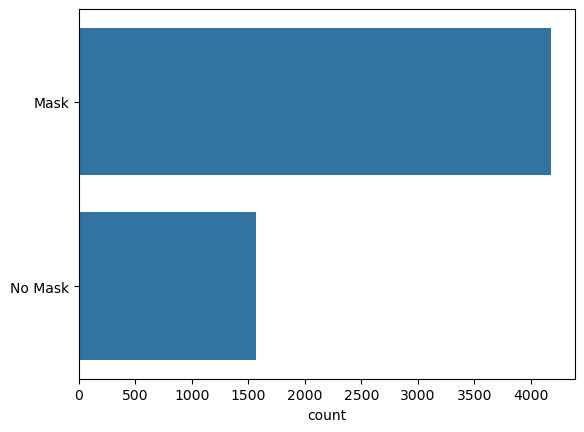

In [7]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels = {'mask':0, 'without mask': 1}

for i in df['name'].unique():
    f = i + '.json'
    for j in getJSON(os.path.join(directory, f)).get("Annotations"):
        if j["classname"] in mask:
            x, y, w, h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory, i), 1)
            img = img[y:h, x:w]
            img = cv2.resize(img, (img_size, img_size))
            data.append([img, labels["mask"]])
        if j["classname"] in non_mask:
            x, y, w, h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory, i), 1)
            img = img[y:h, x:w]
            img = cv2.resize(img, (img_size, img_size))
            data.append([img, labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if face[1] == 0:
        p.append("Mask")
    else:
        p.append("No Mask")

sns.countplot(p)

In [8]:
# Reshaping the data before training
X = []
Y = []
for features, label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/ 255.0
X = X.reshape(-1, 124, 124, 3)
Y = np.array(Y)

**Neural Network for the face mask training**

In [9]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Define the convolution layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size = (3,3), padding = 'same' )
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3))
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3))

        # Maxpooling layer
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)

        # Dropout
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 60 * 60, 50) # The size here depends on the image size
        self.fc2 = nn.Linear(50, 1) # Binary classification, 1 outputnode for sigmoid
        

    def forward(self, x):
        # Convolution layers with activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Maxpool layer with dropout
        x = self.pool(x)
        x = self.dropout1(x)

        # Flattening the output
        x = x.view(x.size(0), -1) # Flattening
        
        # Fully connected layer with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc2(x))

        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

In [11]:
criterion = nn.BCELoss() # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr = 0.001)

**Preapre the dataset for training**

In [12]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size = 0.8, random_state = 0)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Default ImageNet values
])

In [13]:
class FaceMaskDataset(Dataset):
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return(len(self.images))

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        # Apply transformations
        image = self.transform(image)
        return image, label

In [14]:
# Create Datasets and DataLoaders
train_dataset = FaceMaskDataset(x_train, y_train, transform)
val_dataset = FaceMaskDataset(x_val, y_val, transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

In [16]:
# Train model
for epoch in range(50):
    model.train()
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move data to device
        images, labels = images.to(device).float() , labels.to(device).float()
        # Converted the images and labels to single precision because the torch input and weights to be of the same type

        # Zero gradients
        optimizer.zero_grad()

        # Forward Pass
        outputs = model(images)
        outputs = outputs.view(-1)
        loss = criterion(outputs, labels)
        # Backward Pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device).float() , labels.to(device).float() 
            outputs = model(images)
            outputs = outputs.view(-1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # _, predicted = torch.max(outputs, 1) # For multi-class classification
            predicted = (outputs>0.5).float() # For the binary classification
            correct += (predicted == labels).sum().item()

    # Print epoch  metrics
    print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader)}")
    print(f"Epoch {epoch+1}, Val Loss: {val_loss / len(val_loader)}")
    print(f"Epoch {epoch+1}, Val Acc: {correct / len(val_dataset)}")
print("Training Completed.")

Epoch 1, Train Loss: 0.44162239806933534
Epoch 1, Val Loss: 0.3209803917755683
Epoch 1, Val Acc: 0.871304347826087
Epoch 2, Train Loss: 0.29278890250457656
Epoch 2, Val Loss: 0.2711427449766133
Epoch 2, Val Acc: 0.8973913043478261
Epoch 3, Train Loss: 0.2763742485808002
Epoch 3, Val Loss: 0.24622072589894137
Epoch 3, Val Acc: 0.9078260869565218
Epoch 4, Train Loss: 0.2561277516393198
Epoch 4, Val Loss: 0.21258111649917233
Epoch 4, Val Acc: 0.9130434782608695
Epoch 5, Train Loss: 0.23349069938477543
Epoch 5, Val Loss: 0.20422293556233248
Epoch 5, Val Acc: 0.9182608695652174
Epoch 6, Train Loss: 0.23711810933632982
Epoch 6, Val Loss: 0.21939539516137707
Epoch 6, Val Acc: 0.9191304347826087
Epoch 7, Train Loss: 0.22219960616591075
Epoch 7, Val Loss: 0.19178230615539682
Epoch 7, Val Acc: 0.9234782608695652
Epoch 8, Train Loss: 0.20654316259444588
Epoch 8, Val Loss: 0.19836189742717478
Epoch 8, Val Acc: 0.9191304347826087
Epoch 9, Train Loss: 0.2102030827017087
Epoch 9, Val Loss: 0.19904107

In [17]:
torch.save(model.state_dict(), 'model.pth')

**Testing the model**

In [15]:
# cvNet = cv2.dnn.readNetFromCaffe('deploy.prototxt','weights.caffemodel')
# Load Haar Cascade for face detection
cvNet = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

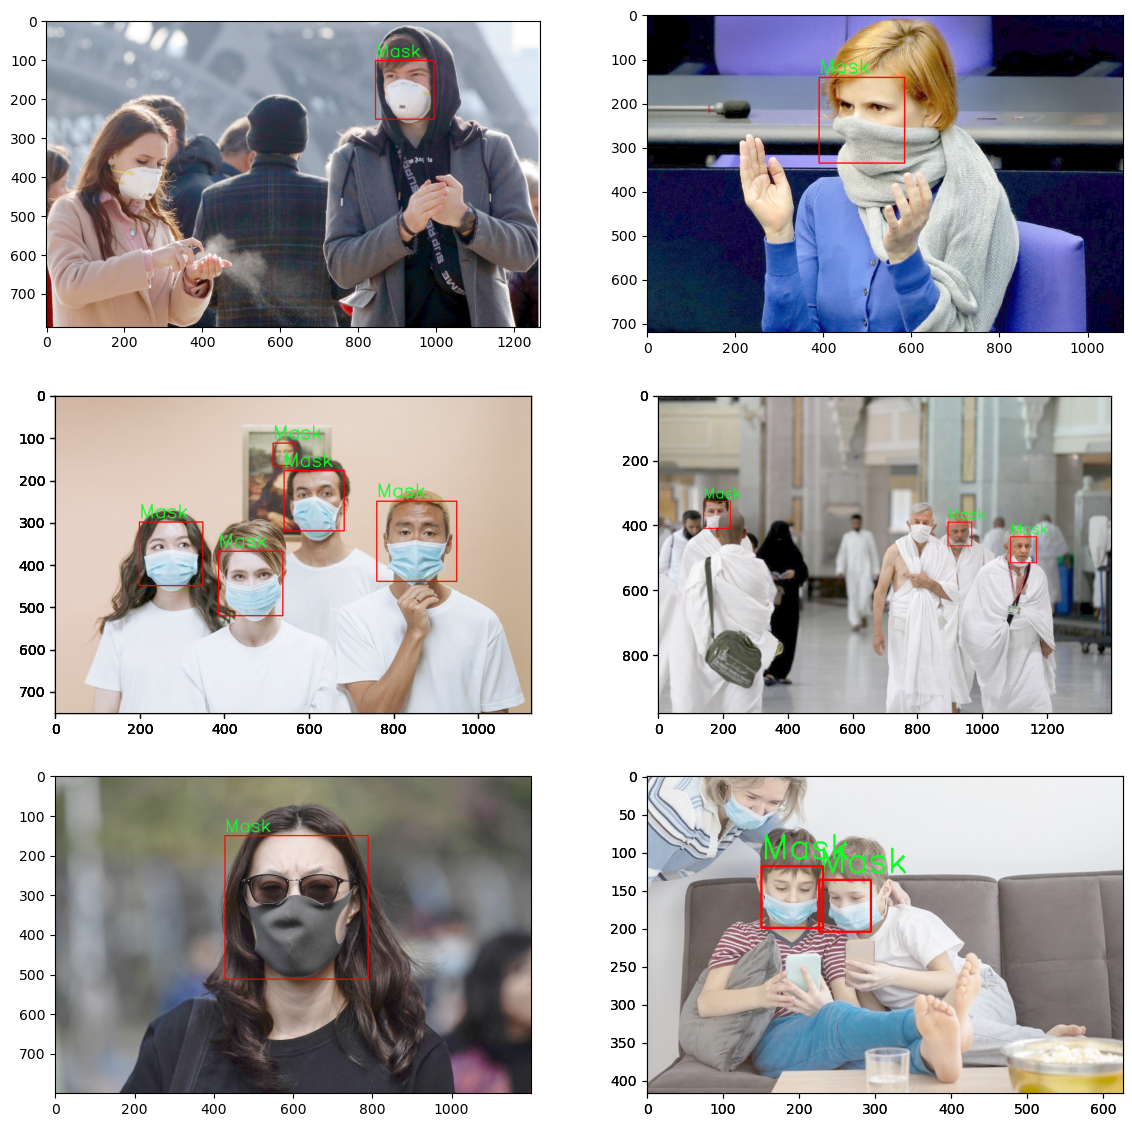

In [16]:
# Loading the model and set it in the evaluation mode
model.load_state_dict(torch.load('model.pth', map_location = torch.device('cpu'), weights_only = True) )
model.eval()

# Image pre-processing function
img_size = 124
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Test images
test_images = ['0114.png', '1514.jpg', '0072.jpg', '0012.jpg', '0343.jpg', '1342.jpg']
gamma = 2.0

fig = plt.figure(figsize=(14, 14))
rows = 3
cols = 2
assign = {0: 'Mask', 1: 'No MAsk'}

for j, im_name in enumerate(test_images):
    # Read the image
    image = cv2.imread(os.path.join(image_directory, im_name))
    image = adjust_gamma(image, gamma = gamma)
    (h, w) = image.shape[:2]

     # Convert the image to grayscal for the face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

     # Detect the face using Haar Cascade
    faces = cvNet.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5, minSize=(30, 30))
    for (startX, startY, width, height) in faces:
        # define the end point of the rectangels
        endX = startX + width
        endY = startY+ height

        # Crop the face region
        face = image[startY:endY, startX:endX]

        # Preprocess the face for the mask detection
        face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        face_tensor = transform(face_pil)
        face_tensor = face_tensor.unsqueeze(0) # Add batch dimension'

        # Perform the mask prediction
        with torch.no_grad():
            face_tensor = face_tensor.to(device)
            output = model(face_tensor)
            result = torch.sigmoid(output).item()

       # Assign label based on the prediction
        label_Y = 0 if result > 0.5 else 1

         # Draw the bounding box and label
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
        cv2.putText(image, assign[label_Y], (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36, 255, 12), 2)

        # Plot the image
        ax = fig.add_subplot(rows, cols, j + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
plt.show()